# PROJECT 2 : TEAM 11

Members: Talia Tandler, SeungU Lyu

In [43]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math

http://www.worldometers.info/world-population/us-population/
US pop in 2017 = 324,459,463

https://www.cdc.gov/vaccines/imz-managers/coverage/childvaxview/data-reports/mmr/trend/index.html
MMR immunization rate in 2017 = 90.7%

https://www.acha.org/documents/Programs_Services/ConEd/Measles_Update_2015_Implications_for_the_College_Setting.pdfMMR 
Measles importatoin number = 33/year

https://wwwnc.cdc.gov/travel/yellowbook/2018/infectious-diseases-related-to-travel/measles-rubeola
Measles incubation period 11 days average, infectious period 2-4 days before rash to after rash.

https://www.researchgate.net/figure/Daily-average-number-of-contacts-per-person-in-age-group-j-The-average-number-of_fig2_228649013
Daily average number of contacts per person. 

https://academic.oup.com/jid/article/189/Supplement_1/S91/825077
1999 overall immunity for measles were expected to be 93% for US population.

https://www.statista.com/statistics/195943/birth-rate-in-the-united-states-since-1990/
Birth rate = 12.2/1000 per year = 0.0122 
Death rate = 8.4/1000 per year = 0.0084


In [375]:
us_pop = 324459463
init_im = 0.93
MMR_vac = .907 #MMR vaccination rate in 2017
a_rate = 0.9 #Possibility of getting measles if you come into contact with someone that has it
b_rate = 0.0122
d_rate = 0.0084
r_rate = 0.25
i_rate = 0.091
c_num = 12

12

In [389]:
def make_system (us_pop, init_im, vac_rate, b_rate, d_rate, r_rate, i_rate, c_num, a_rate):
    """Make a system object for the SCIR model
    
    us_pop: Total US population
    init_im: Initial Population Immunity
    vac_rate: Vaccination rate for newborn
    b_rate: birth rate per 1000 people
    d_rate: death rate per 1000 people
    r_rate: recovery rate for infected people
    i_rate: rate of incubation group moving to infectious group
    c_num: initial contact number for individuals 
    a_rate: Possibility of getting measles if you come into contact with someone that has it
    
    return: System object"""
    
    init = State(S = int(us_pop*(1 - init_im)), C = 0, I = 0, R = int(us_pop*init_im), T = 0, O = 0)
    #S: susceptible, C: incubation period, I: infected, R: recovered(immune to disease), T: total infected, O: outbreak status
    
    t0 = 0
    t_end = 8000 #number of days in 10 years
    
    return System(init = init,
                  vac_rate = vac_rate,
                  b_rate = b_rate,
                  d_rate = d_rate,
                  r_rate = r_rate,
                  i_rate = i_rate,
                  c_num = c_num,
                  a_rate = a_rate,
                  t0 = t0,
                  t_end = t_end)

In [390]:
def update_func(state, t, system, contact):
    """Update the SCIR model
    
    state: starting variables of SCIR
    t: time step
    system: includes alpha,beta,gamma,omega rates
    contact: current contact number for the state
    
    """
    
    unpack(system)
    
    s,c,i,r,t,o = state
    
    #posibility of change in C on major outbreak.
    probability = 1 - exp(-0.1*i)
    
    #outbreak status check
    if o == 0 and i >= 3:
        o = 1
    
    #if measles outbreak is happening, change the contact number
    if o == 1:
        if flip(probability) and contact > 0:
            contact -= 1
    
    #end the outbreak when balance between C and I happens
    if o == 1 and c <= 10 and i <= 3 and contact == 0:
        c = 0
        i = 0
        o = 0
        contact = c_num
            
    #current population
    current_pop = s+c+i+r
    
    #newborn babies number every day
    newborn = int((b_rate * (current_pop))/365)
    
    #importation of measles from other countries
    if flip(0.091):
        i += 1
        t += 1
    
    #change rate for each status
    ds = int(newborn * (1-vac_rate) - (d_rate * s)/365)
    dr1 = int(newborn * vac_rate - (d_rate * r)/365)
    dc = int(contact * i * a_rate * (s/(s+r+c)))
    di = int(c * i_rate)
    dr2 = int(i * (r_rate))
  
    s += ds - dc
    i += di - dr2
    c += dc - di
    r += dr1 + dr2
    t += dc
    
    return State(S=s, C=c, I=i, R=r, T=t, O=o), contact

In [391]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    #creates timeframe to save daily states
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    #creating contact number with initial value c_num
    contact = c_num
    
    for t in linrange(t0, t_end):
        frame.row[t+1], contact = update_func(frame.row[t], t, system, contact)
    
    return frame

In [394]:
vac_rate = 0.9
system = make_system(us_pop, init_im, vac_rate, b_rate, d_rate, r_rate, i_rate, c_num, a_rate)
results = run_simulation(system, update_func)
results
#plot(results['I'], label='L')

,S,C,I,R,T,O
0,22712162,0,0,301747300,0,0
1,22712723,0,0,301750115,0,0
2,22713284,0,0,301752931,0,0
3,22713845,0,1,301755747,1,0
4,22714406,0,1,301758562,1,0
5,22714967,0,1,301761377,1,0
6,22715528,0,1,301764192,1,0
7,22716089,0,1,301767007,1,0
8,22716650,0,1,301769822,1,0
9,22717211,0,1,301772637,1,0


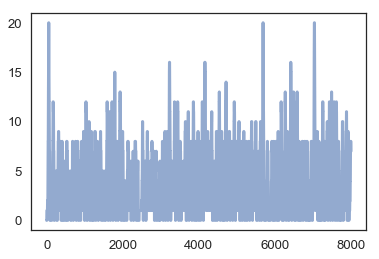

In [395]:
#plot(results['S'], label='R')
plot(results['I'], label='L')
#plot(results['R'], label='E')

In [315]:
test = TimeSeries()
for t in linspace(0,100):
    test[t] = 1 - exp(-0.1*t)
test

,values
0.000000,0.000000
2.040816,0.184604
4.081633,0.335130
6.122449,0.457868
8.163265,0.557947
10.204082,0.639552
12.244898,0.706092
14.285714,0.760349
16.326531,0.804590
18.367347,0.840663
